# Mixture Models and EM

In [151]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm
from random import shuffle
cor = ['#fad390', '#f6b93b', '#fa983a', '#e58e26', '#f8c291', '#e55039', '#eb2f06', '#b71540']
cog = ['#b8e994', '#78e08f', '#38ada9', '#079992']
cob = ['#6a89cc', '#4a69bd', '#1e3799', '#0c2461', '#82ccdd', '#60a3bc', '#3c6382', '#0a3d62']
mixed = cor[:3]+cog[:3]+cob[:3]
shuffle(mixed)

---
##### Summary
* Goals:
    1. Implement K(=2)-means algorithm
    2. Implement EM algorithm for a mixture of two Gaussians.
* Details:
    1. Bishop, PRML, Chapter 9.
---

### K-means clustering

In [83]:
# generate datasets
n = 50
x1 = normal([-1,-1], 0.2*np.eye(2)).rvs(n)
x2 = normal([+1,+1], 0.2*np.eye(2)).rvs(n)
x = np.concatenate((x1,x2), axis=0)
np.random.shuffle(x)

mu, cov = np.mean(x, axis=0), np.cov(x.T)
x = (np.linalg.inv(np.linalg.cholesky(cov)) @ x.T).T

#plt.plot(x[:,0], x[:,1], 'o', color='green');

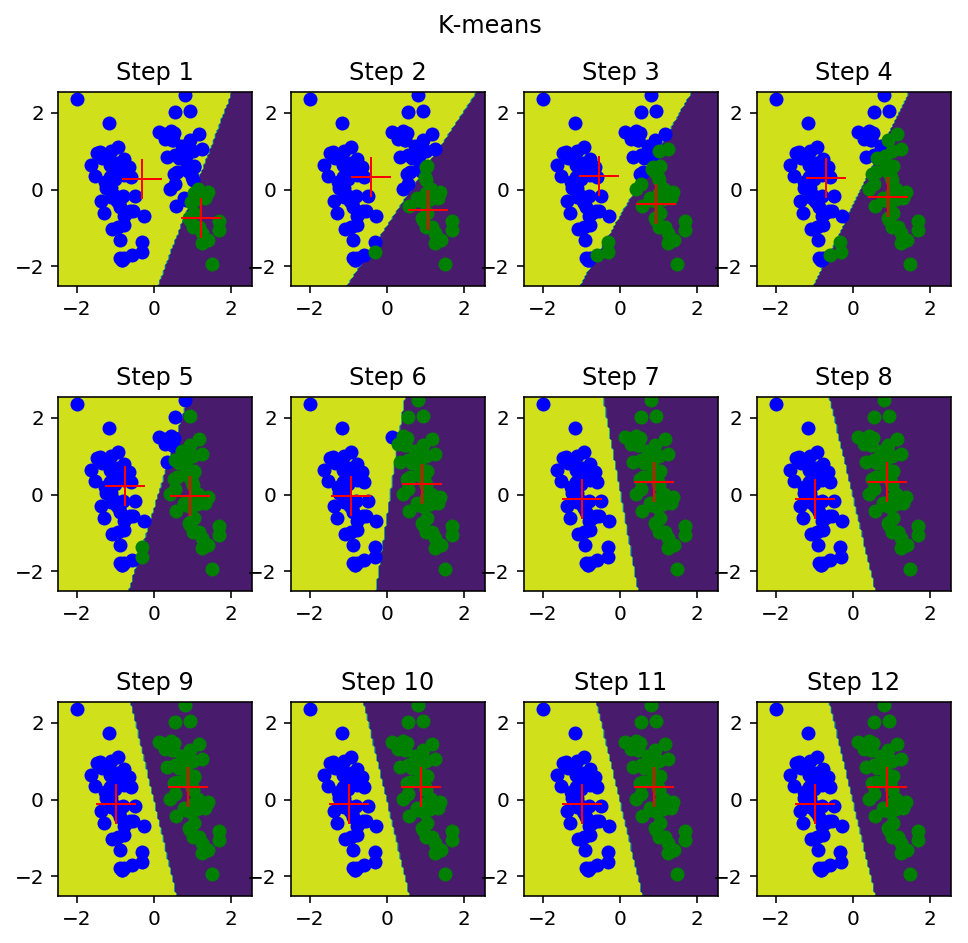

In [78]:
steps = 12
#mu1, mu2 = np.array([0.1,-0.3]), np.array([1,-1])
mu1, mu2 = np.random.normal(size=2), np.random.normal(size=2) # random initialisation of means
plt.figure(figsize=(8,3*steps/2.2))
plt.suptitle('K-means', y=0.9)
for i in range(steps):
    # E step: calculate responsibilities
    rn1 = np.sum(np.square(x-mu1), axis=1, keepdims=True)
    rn2 = np.sum(np.square(x-mu2), axis=1, keepdims=True)
    g1, g2 = np.meshgrid(np.arange(-2.5,+2.5+0.06, 0.05),\
                         np.arange(-2.5,+2.5+0.06, 0.05))
    g = np.c_[g1.ravel(), g2.ravel()]
    g_pred = (np.sum(np.square(g-mu1), axis=1, keepdims=True)<np.sum(np.square(g-mu2), axis=1, keepdims=True)).astype(int).reshape(*g1.shape)
    rn_ = np.concatenate((rn2, rn1), axis=1)
    rn = np.zeros_like(rn_)
    rn[np.arange(rn_.shape[0]), rn_.argmax(1)] = 1
    N = np.sum(rn, axis=0)
    # M step: optimise parameters
    x1 = x[rn[:,0]==1]
    x2 = x[rn[:,1]==1]
    mu1 = np.sum(x1, axis=0)/N[0]
    mu2 = np.sum(x2, axis=0)/N[1]
    J = np.sum(np.square(x1 - mu1)) + np.sum(np.square(x2-mu2))
    plt.subplot(int(steps/2+0.5),4,i+1)
    plt.title('Step {}'.format(i+1))
    plt.contourf(g1, g2, g_pred)
    plt.plot(x1[:,0], x1[:,1], 'bo')
    plt.plot(x2[:,0], x2[:,1], 'go')
    plt.plot(mu1[0], mu1[1], 'r+', ms='20')
    plt.plot(mu2[0], mu2[1], 'r+', ms='20', label='J={:.3f}'.format(J))
    plt.axis('scaled')
    #plt.axis([-2, 2, -2, 2])

### Mixtures of Gaussians (EM)

In [146]:
# generate datasets
n = 50
x1 = normal([-1,-1], 0.2*np.eye(2)).rvs(n)
x2 = normal([+1,+1], 0.8*np.eye(2)).rvs(n)
x = np.concatenate((x1,x2), axis=0)
np.random.shuffle(x)

mu, cov = np.mean(x, axis=0), np.cov(x.T)
x = (np.linalg.inv(np.linalg.cholesky(cov)) @ x.T).T

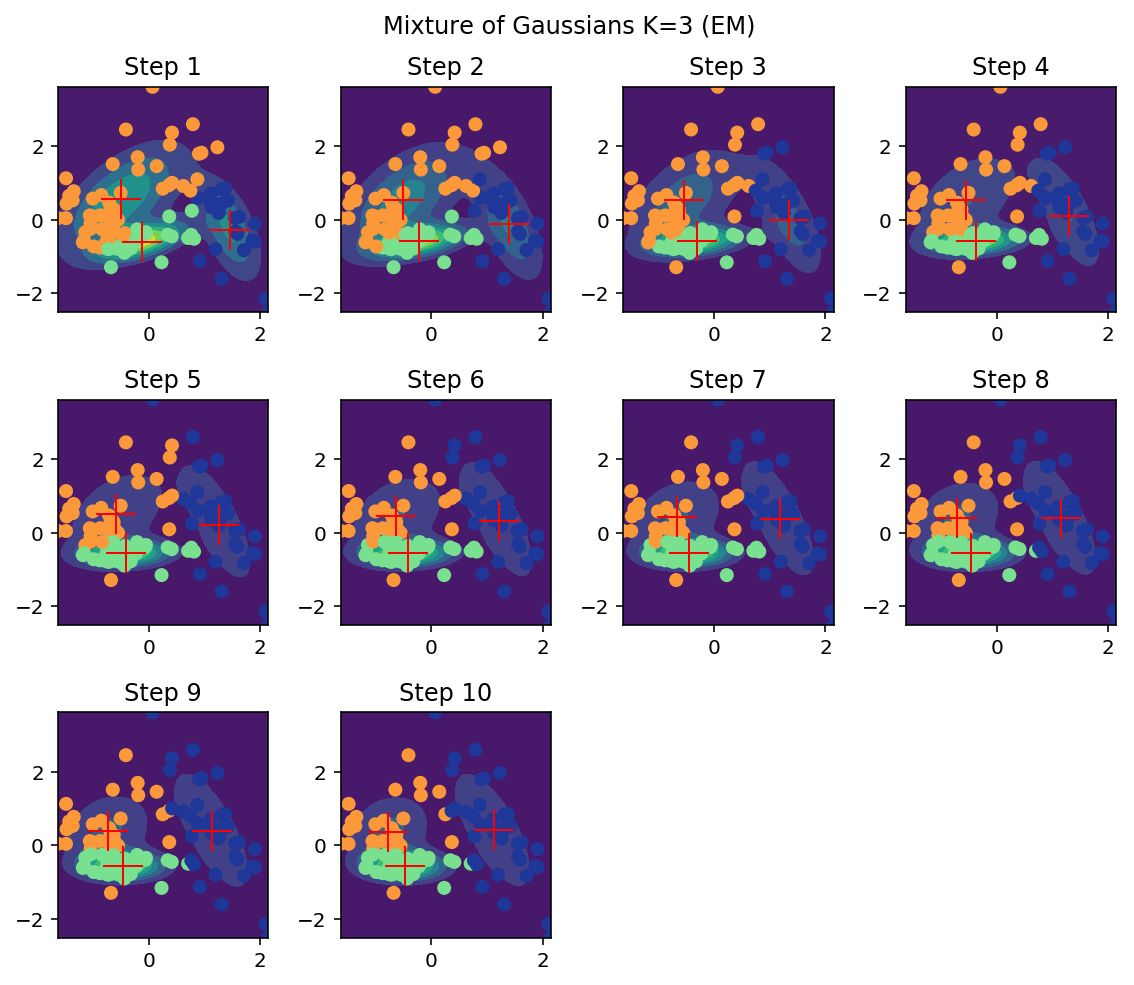

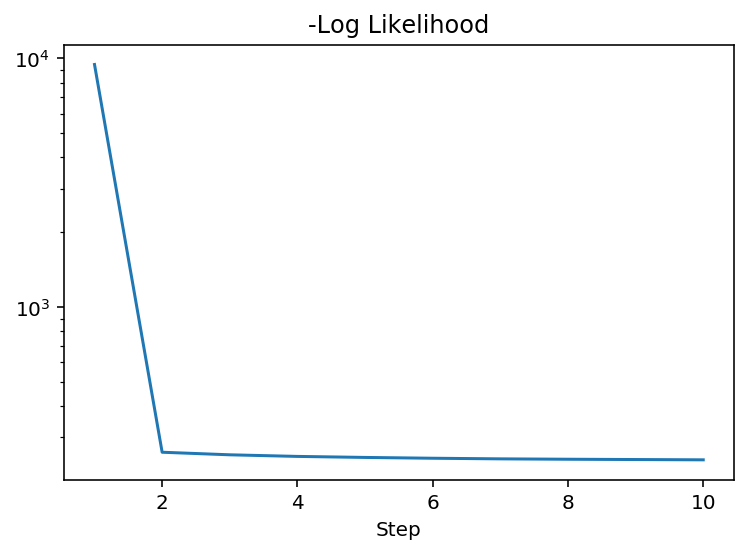

In [152]:
K = 3
pi  = np.ones(shape=(1,K))/K
mu  = np.random.uniform(size=(2,K))
cov = np.c_[[0.01*np.eye(2) for i in range(K)]]
gam = np.zeros((x.shape[0], K)) # responsibilities
steps = 10
plot_every = 1
plot_count = 1
log_likelihood = [0]

plt.figure(figsize=(8,3*steps/4.5/plot_every))
plt.suptitle('Mixture of Gaussians K={} (EM)'.format(K), y=1.02)
for i in range(steps):
    # Expectation
    for k in range(K):
         gam[:,k] = normal(mu[:,k], cov[k,:]).pdf(x) * pi[0][k]
    LL = np.sum(np.log(np.sum(gam, axis=1))) # log likelihood
    log_likelihood.append(LL)
    #if not (i % 10): print('Step {}: LL = {:.3f}'.format(i, LL))
    gam /= np.sum(gam, axis=1)[:,None]
    # Maximisation
    Nk = np.sum(gam, axis=0)
    for k in range(K):
        mu[:,k]  = 1/Nk[k] * np.sum(gam[:,k,None] * x, axis=0) # mean
        cov[k,:] = 1/Nk[k] * (np.sqrt(gam[:,k,None]) * (x - mu[:,k])).T @ (np.sqrt(gam[:,k,None]) * (x - mu[:,k])) # covariance
        pi[0,k]  = Nk[k] / x.shape[0] # coefficients
    
    
    if i % plot_every == 0:
        plt.subplot(int(steps/plot_every/4+0.5),4,plot_count)
        plt.title('Step {}'.format(i+1))
        # Plot
        g1, g2 = np.meshgrid(np.arange(np.min(x[:,0]),np.max(x[:,0])+0.06, 0.05),\
                             np.arange(np.min(x[:,1]),np.max(x[:,1])+0.06, 0.05))
        g = np.c_[g1.ravel(), g2.ravel()]
        g_pred = np.sum(pi * np.concatenate([normal(mu[:,k], cov[k,:]).pdf(g)[:,None] for k in range(K)], axis=1), axis=1).reshape(*g1.shape)

        for k in range(K):
            plt.plot(mu[0,k], mu[1,k], 'r+', ms='20')
        plt.contourf(g1, g2, g_pred)
        plt.scatter(x[:,0], x[:,1], c=[mixed[i] for i in np.argmax(gam, axis=1)])
        plt.axis([np.min(x[:,0]), np.max(x[:,0]), np.min(x[:,1]), np.max(x[:,1])])
        plot_count += 1
    # Early stopping if LL converges 
    #try: np.testing.assert_almost_equal(log_likelihood[-1], log_likelihood[-2], decimal=5)
    #except AssertionError: continue
    #else: break
plt.tight_layout()


plt.figure()
plt.semilogy(np.arange(1,len(log_likelihood),1), -np.array(log_likelihood)[1:])
plt.xlabel('Step')
plt.title('-Log Likelihood');

In [143]:
log_likelihood

[0,
 -7434.718639818328,
 -218.42348696992624,
 -210.12365283076633,
 -209.45696936640832,
 -209.2617656867442,
 -209.17007940571085,
 -209.11978135089748,
 -209.08924652076325,
 -209.06931618586034,
 -209.05556325588026]